In [1]:
%matplotlib inline

In [2]:
#Set model to freely swim
use_free_move = False

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import scipy.optimize
from matplotlib import animation, rc
from IPython.display import HTML


system = System()
pynamics.set_system(__name__,system)

In [4]:
#Defining Constants of System
seg_len = .005
seg_mass = .005
seg_h = 0.04
seg_th = 0.001

lA = Constant(seg_len,'lA',system)
lB = Constant(seg_len,'lB',system)
lC = Constant(seg_len,'lC',system)
lD = Constant(seg_len,'lD',system)
lE = Constant(seg_len,'lE',system)
lF = Constant(seg_len,'lF',system)
lG = Constant(seg_len,'lG',system) #Tail segment
lP = Constant(seg_len*5,'lP',system) #Constrained length

mA = Constant(seg_mass,'mA',system)
mB = Constant(seg_mass,'mB',system)
mC = Constant(seg_mass,'mC',system)
mD = Constant(seg_mass,'mD',system)
mE = Constant(seg_mass,'mE',system)
mF = Constant(seg_mass,'mF',system)
mG = Constant(seg_mass,'mF',system)

g = Constant(9.81,'g',system)
b = Constant(1e-1,'b',system)
k = Constant(1e-1,'k',system)

freq = Constant(.1,'freq',system)
amp = Constant(55*pi/180,'torque',system)
torque = Constant(1e0,'torque',system)


Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)
Ixx_F = Constant(1,'Ixx_F',system)
Iyy_F = Constant(1,'Iyy_F',system)
Izz_F = Constant(1,'Izz_F',system)
Ixx_G = Constant(1,'Ixx_G',system)
Iyy_G = Constant(1,'Iyy_G',system)
Izz_G = Constant(1,'Izz_G',system)

In [5]:
#Set integration tolerance
tol = 1e-6

In [6]:
#Set simulation run time
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qG,qG_d,qG_dd = Differentiable('qG',system)

if use_free_move:
    x,x_d,x_dd = Differentiable('x',system)
    #y,y_d,y_dd = Differentiable('y',system)

In [8]:
#set initial conditions
initialvalues = {}
initialvalues[qA]=50*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=20*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=0*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=-20*pi/180
initialvalues[qE_d]=0*pi/180
initialvalues[qF]=-60*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qG]=0*pi/180
initialvalues[qG_d]=0*pi/180

if use_free_move:
    initialvalues[x]=0*pi/180
    initialvalues[x_d]=0*pi/180
    #initialvalues[y]=0*pi/180
    #initialvalues[y_d]=0*pi/180

statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
#Frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
G = Frame('G',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(N,[0,0,1],qB,system)
C.rotate_fixed_axis(N,[0,0,1],qC,system)
D.rotate_fixed_axis(N,[0,0,1],qD,system)
E.rotate_fixed_axis(N,[0,0,1],qE,system)
F.rotate_fixed_axis(N,[0,0,1],qF,system)
G.rotate_fixed_axis(N,[0,0,1],qG,system)

In [10]:
#Vectors

if use_free_move:
    pNA=x*N.x + 0*N.y + 0*N.z
    pP = lP*N.x + x*N.x
else:
    pNA=0*N.x + 0*N.y + 0*N.z
    pP = lP*N.x
    
pAB= pNA + lA*A.x
pBC = pAB + lB*B.x
pCD = pBC + lC*C.x
pDE = pCD + lD*D.x
pEF = pDE + lE*E.x
pFG = pEF + lF*F.x
pGtip = pFG + lG*G.x

#Center of Mass
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x
pDcm=pCD+lD/2*D.x
pEcm=pDE+lE/2*E.x
pFcm=pEF+lF/2*F.x
pGcm=pFG+lF/2*G.x

#Angular Velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B) 
wBC = B.get_w_to(C)
wCD = C.get_w_to(D) 
wDE = D.get_w_to(E)
wEF = E.get_w_to(F)
wFG = F.get_w_to(G)

#Velocities 
vGtip=pGtip.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
IE = Dyadic.build(E,Ixx_E,Iyy_E,Izz_E)
IF = Dyadic.build(F,Ixx_F,Iyy_F,Izz_F)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyE = Body('BodyE',E,pEcm,mE,IE,system)
BodyF = Body('BodyF',F,pFcm,mF,IF,system)
BodyG = Body('BodyG',G,pGcm,mG,IG,system)

In [11]:
#Forces
system.addforce(torque*sympy.cos(freq*2*pi*system.t)*A.z,wNA)

#Damping Forces
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wFG,wFG)

#Spring Force (Torsion)
system.add_spring_force1(k,(qA)*N.z,wNA) 
system.add_spring_force1(k,(qB-qA)*N.z,wAB)
system.add_spring_force1(k,(qC-qB)*N.z,wBC)
system.add_spring_force1(k,(qD-qC)*N.z,wCD) 
system.add_spring_force1(k,(qE-qD)*N.z,wDE)
system.add_spring_force1(k,(qF-qE)*N.z,wEF)
system.add_spring_force1(k,(qG-qF)*N.z,wFG)

(<pynamics.force.Force at 0x1f48ed8efd0>,
 <pynamics.spring.Spring at 0x1f48ed8edc0>)

In [12]:
#Constraints for initial condition

eq = []

eq.append(pFG-pP)
    
eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))
eq_scalar.append(qG-0)

In [13]:
#Solve for Intial Conditions
if use_free_move:
    qi = [qA,x]
else:
    qi = [qA]
    
qd = [qB,qC,qD,qE,qF,qG]

constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

eq_scalar = [item.subs(constants) for item in eq_scalar]
error = (numpy.array(eq_scalar)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
    
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2022-02-19 23:35:34,671 - pynamics.output - INFO - calculating outputs
2022-02-19 23:35:34,673 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

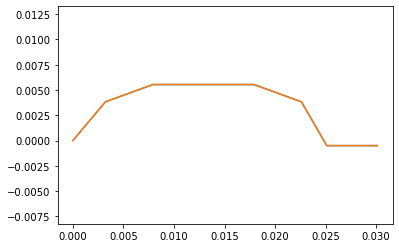

In [14]:
#Plot Initial State
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFG,pGtip]
points_output = PointsOutput(points, constant_values=system.constant_values)
points_output.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points_output.plot_time()

In [15]:
#Solve for Torque at end effector (qG_tip)

#Derivative of constraints
eq_d = [(system.derivative(item)) for item in eq_scalar]
eq_d = sympy.Matrix(eq_d)
eq_d = eq_d.subs(system.constant_values)

qi = sympy.Matrix([qA_d])
qd = sympy.Matrix([qB_d,qC_d,qD_d,qE_d,qF_d,qG_d])

AA = eq_d.jacobian(qi)

BB = eq_d.jacobian(qd)

J_int = -BB.transpose()*AA
J_int

vout = pGtip.time_derivative()
vout = sympy.Matrix([vout.dot(N.x), vout.dot(N.y)])
vout

Ji = vout.jacobian(qi)
Jd = vout.jacobian(qd)

J = Ji + Jd*J_int

J = [item.subs(system.constant_values).subs({qA:ini[0]}) for item in J]
J

[-0.00383022221559489, 0.0032139380484327]

In [16]:
#Adding Dynamic Constraints

#Position of motor limits
pos = amp*sympy.cos(freq*2*pi*system.t)

eq = []

eq.append(pFG-pP)
#eq.append(pos*N.z-qA*N.z)

eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))
#eq_scalar.append(eq[1].dot(N.z))
eq_scalar_d = [system.derivative(item) for item in eq_scalar]
eq_scalar_dd = [system.derivative(item) for item in eq_scalar_d]

system.add_constraint(AccelerationConstraint(eq_scalar_dd))

2022-02-19 23:35:34,965 - pynamics.system - INFO - getting dynamic equations
2022-02-19 23:35:35,747 - pynamics.system - INFO - solving a = f/m and creating function
2022-02-19 23:35:36,650 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-02-19 23:35:36,828 - pynamics.system - INFO - done solving a = f/m and creating function
2022-02-19 23:35:36,847 - pynamics.integration - INFO - beginning integration
2022-02-19 23:35:36,848 - pynamics.system - INFO - integration at time 0000.00
2022-02-19 23:35:37,179 - pynamics.integration - INFO - finished integration


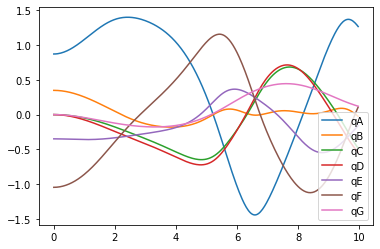

In [17]:
#Solve model and plot angles

f,ma = system.getdynamics()

func1 = system.state_space_post_invert(f,ma,return_lambda = False)

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':system.constant_values},))


plt.figure()
artists = plt.plot(t,states[:,:7])
plt.legend(artists,['qA','qB','qC','qD','qE','qF','qG'])

2022-02-19 23:35:37,419 - pynamics.output - INFO - calculating outputs
2022-02-19 23:35:37,437 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

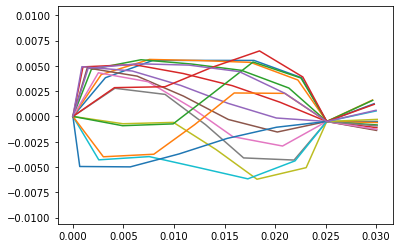

In [18]:
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

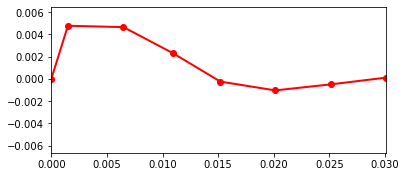

In [19]:
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
HTML(points_output.anim.to_html5_video())

2022-02-19 23:35:51,133 - pynamics.output - INFO - calculating outputs
2022-02-19 23:35:51,200 - pynamics.output - INFO - done calculating outputs


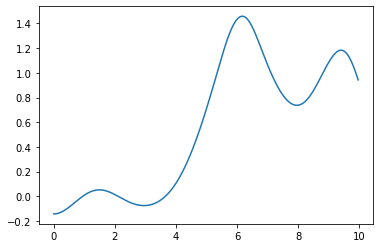

In [20]:
#Energy Plot

KE = system.get_KE()
PE = system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time(t)

Text(0, 0.5, 'Position Y (m)')

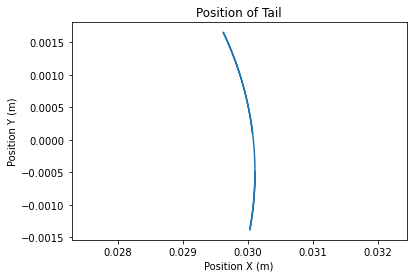

In [21]:
#Plotting Motion of Tail

plt.plot(y[:,7,0],y[:,7,1])
plt.axis('equal')
plt.title('Position of Tail')
plt.xlabel('Position X (m)')
plt.ylabel('Position Y (m)')